In [14]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pylab as plt

def plot_scores(param, paramName, tr_scores, va_scores, log_scale=False):
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.plot(param, tr_scores)
    plt.plot(param, va_scores)
    plt.legend(['train', 'validation'])
    plt.xlabel(paramName)
    plt.ylabel('Accuracy')
    if log_scale:
        plt.xscale('log')
        
        
from hotgrad.variable import Variable
from torch import FloatTensor
from hotgrad.sequential import Sequential
from hotgrad.functions.layers import Linear
from hotgrad.functions.activations import ReLU, Tanh
from hotgrad.functions.losses import MSE
from hotgrad.optimizers import SGD
from torch import cat

from dataset_generator import generate_dataset

# generate the dataset
X_train, X_test, y_train, y_test = generate_dataset(1000, one_hot_encoding=True)
y_train.data = y_train.data*2-1
y_test.data = y_test.data*2-1

X_train_baselines = X_train.data.numpy()
X_test_baselines = X_test.data.numpy()
y_train_baselines = (y_train.data == 1)[:, 1].numpy()
y_test_baselines = (y_test.data == 1)[:, 1].numpy()

X_train.data = (X_train.data - X_train.data.mean())/X_train.data.std() 
X_test.data = (X_test.data - X_test.data.mean())/X_test.data.std() 

X_all = Variable(cat((X_train.data, X_test.data), 0))
y_all = Variable(cat((y_train.data, y_test.data), 0))

## Baselines: Parameters Tuning

### Logistic regression

Best lambda: 2.06913808111479
Test score: 0.521


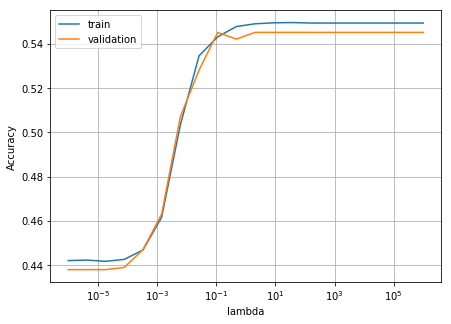

In [15]:
lambdas = np.logspace(-6, 6, 20) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "lambda", logreg["tr_scores"], logreg["va_scores"], log_scale=True)

best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### Random Forest

Best depth: 15
Test score: 0.973


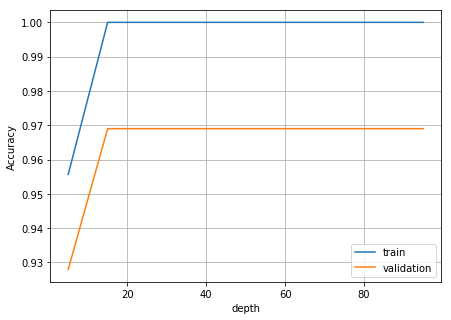

In [16]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], log_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### K-Nearest Neighbors

In [17]:
scaler = StandardScaler()
scaler.fit(X_train_baselines)
X_tr_scaled = scaler.transform(X_train_baselines)
X_te_scaled = scaler.transform(X_test_baselines)
print("standard deviation average:", X_tr_scaled.std(axis=0).mean())
print("mean average:", X_tr_scaled.mean(axis=0).mean())

standard deviation average: 1.0000002
mean average: 5.1148237e-07


In [18]:
pca = PCA(n_components=0.95)
pca.fit(X_tr_scaled)
X_tr_scaled = pca.transform(X_tr_scaled)
X_te_scaled = pca.transform(X_te_scaled)
X_tr_scaled.shape, X_te_scaled.shape

((1000, 2), (1000, 2))

Best k: 6
Test score: 0.979


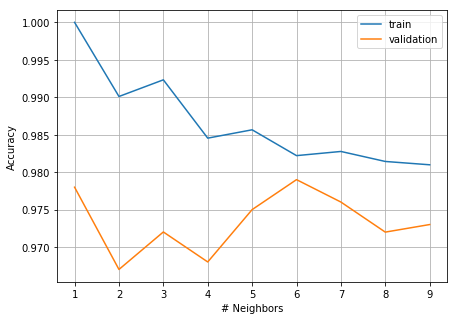

In [19]:
Ks = np.arange(1, 10, 1) # grid search on a parameter of the model

# here we store all the scores obtained with the different number of neighbors
nearestNeig = {
    "tr_scores": [],
    "va_scores": []
}

for k in Ks:
    result = cross_validate(
        KNeighborsClassifier(n_neighbors=k), 
        X_tr_scaled, y_train_baselines, cv=10, return_train_score=True)
    
    nearestNeig["tr_scores"].append(np.mean(result["train_score"]))
    nearestNeig["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(Ks, "# Neighbors", nearestNeig["tr_scores"], nearestNeig["va_scores"], log_scale=False)

best_k = Ks[np.argmax(nearestNeig["va_scores"])]
print('Best k:', best_k)
print('Test score:', 
      KNeighborsClassifier(n_neighbors=k)
      .fit(X_tr_scaled, y_train_baselines)
      .score(X_te_scaled, y_test_baselines))

## Models Comparison

In [20]:
logreg = LogisticRegression(C=best_lambda)
randforest = RandomForestClassifier(n_estimators=100, max_depth=best_depth, n_jobs=-1, random_state=1)
knn = KNeighborsClassifier(n_neighbors=best_k)

# model: two input units, two output units, three hidden layers of 25 units
model = Sequential([Linear(2,25), ReLU(), Linear(25,25), ReLU(), Linear(25,25), ReLU(), Linear(25,2), Tanh()], MSE(), SGD(lr=0.01))

print("Running cross validation on Logistic Regression...")
logreg_scores = cross_validate(
   logreg,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on Random Forest...")
randforest_scores = cross_validate(
   randforest,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on KNearest Neighbors...")
knn_scores = cross_validate(
   knn,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=True)

print("Running cross validation on the Sequential Module...")
sequential_scores = model.cross_validate(X_all, y_all, epochs=2000, verbose=True, n_splits=4)

Running cross validation on Logistic Regression...
Running cross validation on Random Forest...
Running cross validation on KNearest Neighbors...
Running cross validation on the Sequential Module...
----------------- fold 1/4 -----------------
Epoch 0: Train loss: 1.5359079837799072. Train accuracy 50.40%. 
Epoch 1: Train loss: 1.524816632270813. Train accuracy 50.40%. 
Epoch 2: Train loss: 1.5158026218414307. Train accuracy 50.40%. 
Epoch 3: Train loss: 1.50855553150177. Train accuracy 50.40%. 
Epoch 4: Train loss: 1.5027787685394287. Train accuracy 50.40%. 
Epoch 5: Train loss: 1.498180627822876. Train accuracy 50.40%. 
Epoch 6: Train loss: 1.4945037364959717. Train accuracy 50.40%. 
Epoch 7: Train loss: 1.4915246963500977. Train accuracy 50.40%. 
Epoch 8: Train loss: 1.489066481590271. Train accuracy 50.40%. 
Epoch 9: Train loss: 1.4869955778121948. Train accuracy 50.40%. 
Epoch 10: Train loss: 1.485208511352539. Train accuracy 50.40%. 
Epoch 11: Train loss: 1.4836280345916748. Trai

Epoch 138: Train loss: 0.9987925291061401. Train accuracy 41.13%. 
Epoch 139: Train loss: 0.9983322024345398. Train accuracy 42.40%. 
Epoch 140: Train loss: 0.9978740215301514. Train accuracy 43.13%. 
Epoch 141: Train loss: 0.9974173903465271. Train accuracy 43.93%. 
Epoch 142: Train loss: 0.9969617128372192. Train accuracy 44.80%. 
Epoch 143: Train loss: 0.9965071678161621. Train accuracy 45.53%. 
Epoch 144: Train loss: 0.9960540533065796. Train accuracy 46.13%. 
Epoch 145: Train loss: 0.9956024885177612. Train accuracy 46.67%. 
Epoch 146: Train loss: 0.9951522946357727. Train accuracy 47.40%. 
Epoch 147: Train loss: 0.9947035312652588. Train accuracy 48.00%. 
Epoch 148: Train loss: 0.994256854057312. Train accuracy 48.60%. 
Epoch 149: Train loss: 0.993811845779419. Train accuracy 49.13%. 
Epoch 150: Train loss: 0.9933685660362244. Train accuracy 49.73%. 
Epoch 151: Train loss: 0.992927610874176. Train accuracy 50.27%. 
Epoch 152: Train loss: 0.9924882650375366. Train accuracy 51.00%.

Epoch 300: Train loss: 0.934257984161377. Train accuracy 66.87%. 
Epoch 301: Train loss: 0.933887779712677. Train accuracy 66.87%. 
Epoch 302: Train loss: 0.933517575263977. Train accuracy 66.93%. 
Epoch 303: Train loss: 0.9331475496292114. Train accuracy 66.93%. 
Epoch 304: Train loss: 0.9327778220176697. Train accuracy 67.00%. 
Epoch 305: Train loss: 0.9324082732200623. Train accuracy 67.00%. 
Epoch 306: Train loss: 0.9320385456085205. Train accuracy 66.93%. 
Epoch 307: Train loss: 0.9316689372062683. Train accuracy 66.93%. 
Epoch 308: Train loss: 0.9312992691993713. Train accuracy 66.93%. 
Epoch 309: Train loss: 0.9309296607971191. Train accuracy 66.93%. 
Epoch 310: Train loss: 0.9305603504180908. Train accuracy 66.93%. 
Epoch 311: Train loss: 0.9301910400390625. Train accuracy 66.87%. 
Epoch 312: Train loss: 0.9298218488693237. Train accuracy 66.80%. 
Epoch 313: Train loss: 0.9294524192810059. Train accuracy 66.67%. 
Epoch 314: Train loss: 0.9290823340415955. Train accuracy 66.67%.

Epoch 458: Train loss: 0.8712334632873535. Train accuracy 70.00%. 
Epoch 459: Train loss: 0.8707770705223083. Train accuracy 70.00%. 
Epoch 460: Train loss: 0.8703194260597229. Train accuracy 70.00%. 
Epoch 461: Train loss: 0.8698607087135315. Train accuracy 70.07%. 
Epoch 462: Train loss: 0.8694009780883789. Train accuracy 70.07%. 
Epoch 463: Train loss: 0.8689398169517517. Train accuracy 70.07%. 
Epoch 464: Train loss: 0.8684777021408081. Train accuracy 70.07%. 
Epoch 465: Train loss: 0.8680136799812317. Train accuracy 70.13%. 
Epoch 466: Train loss: 0.8675482273101807. Train accuracy 70.20%. 
Epoch 467: Train loss: 0.8670817017555237. Train accuracy 70.20%. 
Epoch 468: Train loss: 0.8666137456893921. Train accuracy 70.27%. 
Epoch 469: Train loss: 0.866144597530365. Train accuracy 70.40%. 
Epoch 470: Train loss: 0.8656740784645081. Train accuracy 70.47%. 
Epoch 471: Train loss: 0.8652025461196899. Train accuracy 70.47%. 
Epoch 472: Train loss: 0.8647298812866211. Train accuracy 70.47

Epoch 627: Train loss: 0.7691798210144043. Train accuracy 76.67%. 
Epoch 628: Train loss: 0.7683783769607544. Train accuracy 76.67%. 
Epoch 629: Train loss: 0.767573893070221. Train accuracy 76.73%. 
Epoch 630: Train loss: 0.7667664885520935. Train accuracy 76.80%. 
Epoch 631: Train loss: 0.7659562230110168. Train accuracy 76.80%. 
Epoch 632: Train loss: 0.7651429772377014. Train accuracy 76.80%. 
Epoch 633: Train loss: 0.7643267512321472. Train accuracy 76.93%. 
Epoch 634: Train loss: 0.7635074257850647. Train accuracy 77.07%. 
Epoch 635: Train loss: 0.7626845240592957. Train accuracy 77.13%. 
Epoch 636: Train loss: 0.7618581652641296. Train accuracy 77.20%. 
Epoch 637: Train loss: 0.7610286474227905. Train accuracy 77.20%. 
Epoch 638: Train loss: 0.7601961493492126. Train accuracy 77.27%. 
Epoch 639: Train loss: 0.7593600749969482. Train accuracy 77.20%. 
Epoch 640: Train loss: 0.7585204839706421. Train accuracy 77.20%. 
Epoch 641: Train loss: 0.7576777935028076. Train accuracy 77.13

Epoch 751: Train loss: 0.6430000066757202. Train accuracy 80.33%. 
Epoch 752: Train loss: 0.6417443156242371. Train accuracy 80.47%. 
Epoch 753: Train loss: 0.6404836773872375. Train accuracy 80.47%. 
Epoch 754: Train loss: 0.6392191052436829. Train accuracy 80.47%. 
Epoch 755: Train loss: 0.6379504203796387. Train accuracy 80.53%. 
Epoch 756: Train loss: 0.6366775631904602. Train accuracy 80.60%. 
Epoch 757: Train loss: 0.635399580001831. Train accuracy 80.67%. 
Epoch 758: Train loss: 0.6341173648834229. Train accuracy 80.67%. 
Epoch 759: Train loss: 0.6328309774398804. Train accuracy 80.60%. 
Epoch 760: Train loss: 0.6315408945083618. Train accuracy 80.60%. 
Epoch 761: Train loss: 0.6302480697631836. Train accuracy 80.60%. 
Epoch 762: Train loss: 0.6289518475532532. Train accuracy 80.87%. 
Epoch 763: Train loss: 0.6276509761810303. Train accuracy 80.93%. 
Epoch 764: Train loss: 0.6263471245765686. Train accuracy 81.00%. 
Epoch 765: Train loss: 0.6250395178794861. Train accuracy 81.13

Epoch 894: Train loss: 0.4345880448818207. Train accuracy 91.87%. 
Epoch 895: Train loss: 0.4331003725528717. Train accuracy 91.93%. 
Epoch 896: Train loss: 0.43161723017692566. Train accuracy 92.07%. 
Epoch 897: Train loss: 0.430137574672699. Train accuracy 92.13%. 
Epoch 898: Train loss: 0.42866215109825134. Train accuracy 92.13%. 
Epoch 899: Train loss: 0.4271901845932007. Train accuracy 92.27%. 
Epoch 900: Train loss: 0.4257219433784485. Train accuracy 92.33%. 
Epoch 901: Train loss: 0.424258828163147. Train accuracy 92.47%. 
Epoch 902: Train loss: 0.422802597284317. Train accuracy 92.67%. 
Epoch 903: Train loss: 0.421353280544281. Train accuracy 92.67%. 
Epoch 904: Train loss: 0.41990840435028076. Train accuracy 92.93%. 
Epoch 905: Train loss: 0.41846752166748047. Train accuracy 93.00%. 
Epoch 906: Train loss: 0.41703149676322937. Train accuracy 93.07%. 
Epoch 907: Train loss: 0.4156005382537842. Train accuracy 93.13%. 
Epoch 908: Train loss: 0.4141739308834076. Train accuracy 93.

Epoch 1040: Train loss: 0.2745364010334015. Train accuracy 97.27%. 
Epoch 1041: Train loss: 0.27380380034446716. Train accuracy 97.27%. 
Epoch 1042: Train loss: 0.2730752229690552. Train accuracy 97.27%. 
Epoch 1043: Train loss: 0.2723514139652252. Train accuracy 97.27%. 
Epoch 1044: Train loss: 0.2716314196586609. Train accuracy 97.27%. 
Epoch 1045: Train loss: 0.2709153890609741. Train accuracy 97.27%. 
Epoch 1046: Train loss: 0.27020299434661865. Train accuracy 97.27%. 
Epoch 1047: Train loss: 0.2694944143295288. Train accuracy 97.27%. 
Epoch 1048: Train loss: 0.2687893509864807. Train accuracy 97.27%. 
Epoch 1049: Train loss: 0.26808780431747437. Train accuracy 97.27%. 
Epoch 1050: Train loss: 0.2673899233341217. Train accuracy 97.27%. 
Epoch 1051: Train loss: 0.266696035861969. Train accuracy 97.27%. 
Epoch 1052: Train loss: 0.26600590348243713. Train accuracy 97.27%. 
Epoch 1053: Train loss: 0.2653194069862366. Train accuracy 97.27%. 
Epoch 1054: Train loss: 0.2646362781524658. T

Epoch 1194: Train loss: 0.1951657086610794. Train accuracy 97.87%. 
Epoch 1195: Train loss: 0.19480417668819427. Train accuracy 97.87%. 
Epoch 1196: Train loss: 0.19444403052330017. Train accuracy 97.93%. 
Epoch 1197: Train loss: 0.19408531486988068. Train accuracy 97.93%. 
Epoch 1198: Train loss: 0.19372805953025818. Train accuracy 97.93%. 
Epoch 1199: Train loss: 0.19337217509746552. Train accuracy 97.93%. 
Epoch 1200: Train loss: 0.19301769137382507. Train accuracy 97.93%. 
Epoch 1201: Train loss: 0.19266468286514282. Train accuracy 97.93%. 
Epoch 1202: Train loss: 0.19231350719928741. Train accuracy 97.93%. 
Epoch 1203: Train loss: 0.19196370244026184. Train accuracy 97.93%. 
Epoch 1204: Train loss: 0.19161565601825714. Train accuracy 97.93%. 
Epoch 1205: Train loss: 0.19126936793327332. Train accuracy 97.93%. 
Epoch 1206: Train loss: 0.1909244805574417. Train accuracy 97.93%. 
Epoch 1207: Train loss: 0.1905808448791504. Train accuracy 97.93%. 
Epoch 1208: Train loss: 0.19023796916

Epoch 1328: Train loss: 0.15742173790931702. Train accuracy 98.00%. 
Epoch 1329: Train loss: 0.15720234811306. Train accuracy 98.00%. 
Epoch 1330: Train loss: 0.15698376297950745. Train accuracy 98.00%. 
Epoch 1331: Train loss: 0.15676593780517578. Train accuracy 98.00%. 
Epoch 1332: Train loss: 0.15654879808425903. Train accuracy 98.00%. 
Epoch 1333: Train loss: 0.15633216500282288. Train accuracy 98.00%. 
Epoch 1334: Train loss: 0.15611617267131805. Train accuracy 98.00%. 
Epoch 1335: Train loss: 0.15590092539787292. Train accuracy 98.00%. 
Epoch 1336: Train loss: 0.1556864082813263. Train accuracy 98.00%. 
Epoch 1337: Train loss: 0.15547263622283936. Train accuracy 98.00%. 
Epoch 1338: Train loss: 0.1552593857049942. Train accuracy 98.00%. 
Epoch 1339: Train loss: 0.15504631400108337. Train accuracy 98.00%. 
Epoch 1340: Train loss: 0.15483394265174866. Train accuracy 98.07%. 
Epoch 1341: Train loss: 0.15462230145931244. Train accuracy 98.07%. 
Epoch 1342: Train loss: 0.1544113457202

Epoch 1491: Train loss: 0.12915581464767456. Train accuracy 98.47%. 
Epoch 1492: Train loss: 0.1290198117494583. Train accuracy 98.47%. 
Epoch 1493: Train loss: 0.12888416647911072. Train accuracy 98.47%. 
Epoch 1494: Train loss: 0.12874889373779297. Train accuracy 98.47%. 
Epoch 1495: Train loss: 0.12861397862434387. Train accuracy 98.47%. 
Epoch 1496: Train loss: 0.12847942113876343. Train accuracy 98.47%. 
Epoch 1497: Train loss: 0.12834517657756805. Train accuracy 98.47%. 
Epoch 1498: Train loss: 0.12821128964424133. Train accuracy 98.47%. 
Epoch 1499: Train loss: 0.12807774543762207. Train accuracy 98.47%. 
Epoch 1500: Train loss: 0.12794452905654907. Train accuracy 98.47%. 
Epoch 1501: Train loss: 0.12781168520450592. Train accuracy 98.53%. 
Epoch 1502: Train loss: 0.12767916917800903. Train accuracy 98.53%. 
Epoch 1503: Train loss: 0.12754696607589722. Train accuracy 98.53%. 
Epoch 1504: Train loss: 0.12741510570049286. Train accuracy 98.53%. 
Epoch 1505: Train loss: 0.127283617

Epoch 1646: Train loss: 0.11147266626358032. Train accuracy 98.53%. 
Epoch 1647: Train loss: 0.11137661337852478. Train accuracy 98.53%. 
Epoch 1648: Train loss: 0.11128078401088715. Train accuracy 98.53%. 
Epoch 1649: Train loss: 0.11118524521589279. Train accuracy 98.53%. 
Epoch 1650: Train loss: 0.11108982563018799. Train accuracy 98.53%. 
Epoch 1651: Train loss: 0.11099468916654587. Train accuracy 98.53%. 
Epoch 1652: Train loss: 0.11089976876974106. Train accuracy 98.53%. 
Epoch 1653: Train loss: 0.11080499738454819. Train accuracy 98.53%. 
Epoch 1654: Train loss: 0.11071047931909561. Train accuracy 98.53%. 
Epoch 1655: Train loss: 0.11061607301235199. Train accuracy 98.53%. 
Epoch 1656: Train loss: 0.11052193492650986. Train accuracy 98.53%. 
Epoch 1657: Train loss: 0.11042796075344086. Train accuracy 98.53%. 
Epoch 1658: Train loss: 0.11033418029546738. Train accuracy 98.53%. 
Epoch 1659: Train loss: 0.11024066060781479. Train accuracy 98.53%. 
Epoch 1660: Train loss: 0.11014729

Epoch 1799: Train loss: 0.09869179874658585. Train accuracy 98.67%. 
Epoch 1800: Train loss: 0.09861955791711807. Train accuracy 98.67%. 
Epoch 1801: Train loss: 0.09854752570390701. Train accuracy 98.67%. 
Epoch 1802: Train loss: 0.09847553819417953. Train accuracy 98.67%. 
Epoch 1803: Train loss: 0.09840375930070877. Train accuracy 98.67%. 
Epoch 1804: Train loss: 0.09833201766014099. Train accuracy 98.67%. 
Epoch 1805: Train loss: 0.09826046228408813. Train accuracy 98.67%. 
Epoch 1806: Train loss: 0.09818899631500244. Train accuracy 98.67%. 
Epoch 1807: Train loss: 0.09811767190694809. Train accuracy 98.67%. 
Epoch 1808: Train loss: 0.09804683923721313. Train accuracy 98.67%. 
Epoch 1809: Train loss: 0.09797634929418564. Train accuracy 98.67%. 
Epoch 1810: Train loss: 0.09790608286857605. Train accuracy 98.67%. 
Epoch 1811: Train loss: 0.09783598780632019. Train accuracy 98.67%. 
Epoch 1812: Train loss: 0.09776608645915985. Train accuracy 98.67%. 
Epoch 1813: Train loss: 0.09769636

Epoch 1953: Train loss: 0.0891178622841835. Train accuracy 98.67%. 
Epoch 1954: Train loss: 0.08906322717666626. Train accuracy 98.67%. 
Epoch 1955: Train loss: 0.08900866657495499. Train accuracy 98.67%. 
Epoch 1956: Train loss: 0.0889541432261467. Train accuracy 98.67%. 
Epoch 1957: Train loss: 0.08889956772327423. Train accuracy 98.67%. 
Epoch 1958: Train loss: 0.08884510397911072. Train accuracy 98.67%. 
Epoch 1959: Train loss: 0.08879069238901138. Train accuracy 98.67%. 
Epoch 1960: Train loss: 0.08873636275529861. Train accuracy 98.67%. 
Epoch 1961: Train loss: 0.0886821299791336. Train accuracy 98.67%. 
Epoch 1962: Train loss: 0.08862798660993576. Train accuracy 98.67%. 
Epoch 1963: Train loss: 0.08857392519712448. Train accuracy 98.67%. 
Epoch 1964: Train loss: 0.08851995319128036. Train accuracy 98.67%. 
Epoch 1965: Train loss: 0.08846607804298401. Train accuracy 98.67%. 
Epoch 1966: Train loss: 0.0884120911359787. Train accuracy 98.67%. 
Epoch 1967: Train loss: 0.088357627391

Epoch 94: Train loss: 0.9926785826683044. Train accuracy 67.27%. 
Epoch 95: Train loss: 0.9925117492675781. Train accuracy 67.33%. 
Epoch 96: Train loss: 0.99234539270401. Train accuracy 67.33%. 
Epoch 97: Train loss: 0.992179811000824. Train accuracy 67.33%. 
Epoch 98: Train loss: 0.9920148849487305. Train accuracy 67.47%. 
Epoch 99: Train loss: 0.9918504953384399. Train accuracy 67.60%. 
Epoch 100: Train loss: 0.991686224937439. Train accuracy 67.73%. 
Epoch 101: Train loss: 0.9915220141410828. Train accuracy 67.73%. 
Epoch 102: Train loss: 0.9913583993911743. Train accuracy 67.80%. 
Epoch 103: Train loss: 0.9911951422691345. Train accuracy 67.87%. 
Epoch 104: Train loss: 0.9910318851470947. Train accuracy 67.87%. 
Epoch 105: Train loss: 0.9908686280250549. Train accuracy 67.93%. 
Epoch 106: Train loss: 0.9907057881355286. Train accuracy 67.93%. 
Epoch 107: Train loss: 0.9905431866645813. Train accuracy 67.93%. 
Epoch 108: Train loss: 0.9903810620307922. Train accuracy 68.00%. 
Epoch

Epoch 242: Train loss: 0.965564489364624. Train accuracy 77.80%. 
Epoch 243: Train loss: 0.9653351902961731. Train accuracy 78.00%. 
Epoch 244: Train loss: 0.9651044607162476. Train accuracy 78.27%. 
Epoch 245: Train loss: 0.9648715853691101. Train accuracy 78.53%. 
Epoch 246: Train loss: 0.9646366834640503. Train accuracy 78.53%. 
Epoch 247: Train loss: 0.9644002914428711. Train accuracy 78.53%. 
Epoch 248: Train loss: 0.9641627669334412. Train accuracy 78.67%. 
Epoch 249: Train loss: 0.9639225006103516. Train accuracy 78.87%. 
Epoch 250: Train loss: 0.9636797308921814. Train accuracy 79.13%. 
Epoch 251: Train loss: 0.963435173034668. Train accuracy 79.27%. 
Epoch 252: Train loss: 0.9631877541542053. Train accuracy 79.40%. 
Epoch 253: Train loss: 0.9629381895065308. Train accuracy 79.40%. 
Epoch 254: Train loss: 0.9626862406730652. Train accuracy 79.67%. 
Epoch 255: Train loss: 0.9624323844909668. Train accuracy 79.73%. 
Epoch 256: Train loss: 0.9621770977973938. Train accuracy 79.87%

Epoch 391: Train loss: 0.912791907787323. Train accuracy 84.73%. 
Epoch 392: Train loss: 0.9122903943061829. Train accuracy 84.73%. 
Epoch 393: Train loss: 0.9117860794067383. Train accuracy 84.80%. 
Epoch 394: Train loss: 0.9112788438796997. Train accuracy 84.73%. 
Epoch 395: Train loss: 0.9107688069343567. Train accuracy 84.73%. 
Epoch 396: Train loss: 0.9102555513381958. Train accuracy 84.73%. 
Epoch 397: Train loss: 0.9097392559051514. Train accuracy 84.73%. 
Epoch 398: Train loss: 0.9092198014259338. Train accuracy 84.67%. 
Epoch 399: Train loss: 0.9086976647377014. Train accuracy 84.60%. 
Epoch 400: Train loss: 0.9081725478172302. Train accuracy 84.53%. 
Epoch 401: Train loss: 0.9076441526412964. Train accuracy 84.53%. 
Epoch 402: Train loss: 0.9071129560470581. Train accuracy 84.53%. 
Epoch 403: Train loss: 0.906579315662384. Train accuracy 84.53%. 
Epoch 404: Train loss: 0.906042754650116. Train accuracy 84.60%. 
Epoch 405: Train loss: 0.9055032730102539. Train accuracy 84.60%.

Epoch 552: Train loss: 0.7808101177215576. Train accuracy 85.67%. 
Epoch 553: Train loss: 0.779580295085907. Train accuracy 85.67%. 
Epoch 554: Train loss: 0.7783451080322266. Train accuracy 85.67%. 
Epoch 555: Train loss: 0.7771042585372925. Train accuracy 85.67%. 
Epoch 556: Train loss: 0.7758575081825256. Train accuracy 85.67%. 
Epoch 557: Train loss: 0.7746049761772156. Train accuracy 85.67%. 
Epoch 558: Train loss: 0.7733468413352966. Train accuracy 85.67%. 
Epoch 559: Train loss: 0.772083044052124. Train accuracy 85.67%. 
Epoch 560: Train loss: 0.7708132266998291. Train accuracy 85.67%. 
Epoch 561: Train loss: 0.7695379257202148. Train accuracy 85.67%. 
Epoch 562: Train loss: 0.7682574987411499. Train accuracy 85.73%. 
Epoch 563: Train loss: 0.766972005367279. Train accuracy 85.73%. 
Epoch 564: Train loss: 0.7656811475753784. Train accuracy 85.73%. 
Epoch 565: Train loss: 0.7643846869468689. Train accuracy 85.73%. 
Epoch 566: Train loss: 0.7630821466445923. Train accuracy 85.73%.

Epoch 712: Train loss: 0.5400149822235107. Train accuracy 87.53%. 
Epoch 713: Train loss: 0.5384916067123413. Train accuracy 87.53%. 
Epoch 714: Train loss: 0.5369687676429749. Train accuracy 87.53%. 
Epoch 715: Train loss: 0.5354489684104919. Train accuracy 87.53%. 
Epoch 716: Train loss: 0.5339331030845642. Train accuracy 87.53%. 
Epoch 717: Train loss: 0.5324200391769409. Train accuracy 87.53%. 
Epoch 718: Train loss: 0.5309094190597534. Train accuracy 87.53%. 
Epoch 719: Train loss: 0.5294011831283569. Train accuracy 87.53%. 
Epoch 720: Train loss: 0.5278956890106201. Train accuracy 87.53%. 
Epoch 721: Train loss: 0.5263918042182922. Train accuracy 87.60%. 
Epoch 722: Train loss: 0.5248881578445435. Train accuracy 87.67%. 
Epoch 723: Train loss: 0.5233855843544006. Train accuracy 87.73%. 
Epoch 724: Train loss: 0.5218844413757324. Train accuracy 87.73%. 
Epoch 725: Train loss: 0.5203860402107239. Train accuracy 87.73%. 
Epoch 726: Train loss: 0.5188899040222168. Train accuracy 87.7

Epoch 859: Train loss: 0.34537410736083984. Train accuracy 94.73%. 
Epoch 860: Train loss: 0.3442816734313965. Train accuracy 94.73%. 
Epoch 861: Train loss: 0.3431940972805023. Train accuracy 94.87%. 
Epoch 862: Train loss: 0.3421113193035126. Train accuracy 94.80%. 
Epoch 863: Train loss: 0.3410320580005646. Train accuracy 94.80%. 
Epoch 864: Train loss: 0.339956134557724. Train accuracy 94.80%. 
Epoch 865: Train loss: 0.33888572454452515. Train accuracy 94.87%. 
Epoch 866: Train loss: 0.3378201127052307. Train accuracy 94.87%. 
Epoch 867: Train loss: 0.3367585241794586. Train accuracy 94.87%. 
Epoch 868: Train loss: 0.3356969356536865. Train accuracy 94.93%. 
Epoch 869: Train loss: 0.33463960886001587. Train accuracy 94.93%. 
Epoch 870: Train loss: 0.3335869610309601. Train accuracy 94.93%. 
Epoch 871: Train loss: 0.33253777027130127. Train accuracy 94.93%. 
Epoch 872: Train loss: 0.33149442076683044. Train accuracy 94.87%. 
Epoch 873: Train loss: 0.3304555118083954. Train accuracy 

Epoch 1001: Train loss: 0.23254814743995667. Train accuracy 97.13%. 
Epoch 1002: Train loss: 0.23201671242713928. Train accuracy 97.20%. 
Epoch 1003: Train loss: 0.23148809373378754. Train accuracy 97.27%. 
Epoch 1004: Train loss: 0.23096202313899994. Train accuracy 97.27%. 
Epoch 1005: Train loss: 0.2304391860961914. Train accuracy 97.27%. 
Epoch 1006: Train loss: 0.22991903126239777. Train accuracy 97.27%. 
Epoch 1007: Train loss: 0.22940126061439514. Train accuracy 97.27%. 
Epoch 1008: Train loss: 0.22888591885566711. Train accuracy 97.33%. 
Epoch 1009: Train loss: 0.22837284207344055. Train accuracy 97.33%. 
Epoch 1010: Train loss: 0.227860227227211. Train accuracy 97.40%. 
Epoch 1011: Train loss: 0.2273501455783844. Train accuracy 97.40%. 
Epoch 1012: Train loss: 0.22684286534786224. Train accuracy 97.40%. 
Epoch 1013: Train loss: 0.22633826732635498. Train accuracy 97.40%. 
Epoch 1014: Train loss: 0.22583600878715515. Train accuracy 97.33%. 
Epoch 1015: Train loss: 0.225336000323

Epoch 1157: Train loss: 0.17183126509189606. Train accuracy 97.87%. 
Epoch 1158: Train loss: 0.1715545803308487. Train accuracy 97.87%. 
Epoch 1159: Train loss: 0.17127874493598938. Train accuracy 97.87%. 
Epoch 1160: Train loss: 0.17100390791893005. Train accuracy 97.87%. 
Epoch 1161: Train loss: 0.17073003947734833. Train accuracy 97.87%. 
Epoch 1162: Train loss: 0.17045703530311584. Train accuracy 97.87%. 
Epoch 1163: Train loss: 0.17018479108810425. Train accuracy 97.87%. 
Epoch 1164: Train loss: 0.16991354525089264. Train accuracy 97.87%. 
Epoch 1165: Train loss: 0.16964338719844818. Train accuracy 97.87%. 
Epoch 1166: Train loss: 0.1693742871284485. Train accuracy 97.87%. 
Epoch 1167: Train loss: 0.16910570859909058. Train accuracy 97.87%. 
Epoch 1168: Train loss: 0.16883733868598938. Train accuracy 97.87%. 
Epoch 1169: Train loss: 0.16856995224952698. Train accuracy 97.87%. 
Epoch 1170: Train loss: 0.1683035045862198. Train accuracy 97.87%. 
Epoch 1171: Train loss: 0.16803802549

Epoch 1313: Train loss: 0.13803648948669434. Train accuracy 98.33%. 
Epoch 1314: Train loss: 0.13786891102790833. Train accuracy 98.33%. 
Epoch 1315: Train loss: 0.13770177960395813. Train accuracy 98.33%. 
Epoch 1316: Train loss: 0.13753457367420197. Train accuracy 98.33%. 
Epoch 1317: Train loss: 0.1373678594827652. Train accuracy 98.33%. 
Epoch 1318: Train loss: 0.13720165193080902. Train accuracy 98.40%. 
Epoch 1319: Train loss: 0.13703599572181702. Train accuracy 98.40%. 
Epoch 1320: Train loss: 0.1368708610534668. Train accuracy 98.40%. 
Epoch 1321: Train loss: 0.13670614361763. Train accuracy 98.40%. 
Epoch 1322: Train loss: 0.13654188811779022. Train accuracy 98.40%. 
Epoch 1323: Train loss: 0.13637802004814148. Train accuracy 98.40%. 
Epoch 1324: Train loss: 0.13621465861797333. Train accuracy 98.40%. 
Epoch 1325: Train loss: 0.13605178892612457. Train accuracy 98.40%. 
Epoch 1326: Train loss: 0.1358889639377594. Train accuracy 98.40%. 
Epoch 1327: Train loss: 0.13572643697261

Epoch 1454: Train loss: 0.11852126568555832. Train accuracy 98.67%. 
Epoch 1455: Train loss: 0.11840792745351791. Train accuracy 98.67%. 
Epoch 1456: Train loss: 0.11829502880573273. Train accuracy 98.60%. 
Epoch 1457: Train loss: 0.11818265169858932. Train accuracy 98.67%. 
Epoch 1458: Train loss: 0.11807051301002502. Train accuracy 98.67%. 
Epoch 1459: Train loss: 0.1179586723446846. Train accuracy 98.67%. 
Epoch 1460: Train loss: 0.11784710735082626. Train accuracy 98.67%. 
Epoch 1461: Train loss: 0.11773587018251419. Train accuracy 98.67%. 
Epoch 1462: Train loss: 0.1176249086856842. Train accuracy 98.67%. 
Epoch 1463: Train loss: 0.11751418560743332. Train accuracy 98.67%. 
Epoch 1464: Train loss: 0.11740376055240631. Train accuracy 98.67%. 
Epoch 1465: Train loss: 0.1172935888171196. Train accuracy 98.67%. 
Epoch 1466: Train loss: 0.11718373000621796. Train accuracy 98.67%. 
Epoch 1467: Train loss: 0.11707419902086258. Train accuracy 98.67%. 
Epoch 1468: Train loss: 0.11696478724

Epoch 1597: Train loss: 0.104875847697258. Train accuracy 98.67%. 
Epoch 1598: Train loss: 0.10479556769132614. Train accuracy 98.67%. 
Epoch 1599: Train loss: 0.10471553355455399. Train accuracy 98.67%. 
Epoch 1600: Train loss: 0.10463576018810272. Train accuracy 98.67%. 
Epoch 1601: Train loss: 0.10455623269081116. Train accuracy 98.67%. 
Epoch 1602: Train loss: 0.10447695851325989. Train accuracy 98.67%. 
Epoch 1603: Train loss: 0.10439787805080414. Train accuracy 98.67%. 
Epoch 1604: Train loss: 0.10431886464357376. Train accuracy 98.67%. 
Epoch 1605: Train loss: 0.10424008965492249. Train accuracy 98.67%. 
Epoch 1606: Train loss: 0.10416153073310852. Train accuracy 98.67%. 
Epoch 1607: Train loss: 0.10408302396535873. Train accuracy 98.67%. 
Epoch 1608: Train loss: 0.10400477796792984. Train accuracy 98.67%. 
Epoch 1609: Train loss: 0.10392670333385468. Train accuracy 98.67%. 
Epoch 1610: Train loss: 0.10384869575500488. Train accuracy 98.67%. 
Epoch 1611: Train loss: 0.1037707254

Epoch 1743: Train loss: 0.09463471919298172. Train accuracy 98.80%. 
Epoch 1744: Train loss: 0.09457413852214813. Train accuracy 98.80%. 
Epoch 1745: Train loss: 0.0945136770606041. Train accuracy 98.80%. 
Epoch 1746: Train loss: 0.09445330500602722. Train accuracy 98.80%. 
Epoch 1747: Train loss: 0.09439291059970856. Train accuracy 98.80%. 
Epoch 1748: Train loss: 0.09433269500732422. Train accuracy 98.80%. 
Epoch 1749: Train loss: 0.09427247196435928. Train accuracy 98.80%. 
Epoch 1750: Train loss: 0.09421253204345703. Train accuracy 98.80%. 
Epoch 1751: Train loss: 0.0941525250673294. Train accuracy 98.80%. 
Epoch 1752: Train loss: 0.09409274160861969. Train accuracy 98.80%. 
Epoch 1753: Train loss: 0.09403304755687714. Train accuracy 98.80%. 
Epoch 1754: Train loss: 0.09397344291210175. Train accuracy 98.80%. 
Epoch 1755: Train loss: 0.09391400963068008. Train accuracy 98.80%. 
Epoch 1756: Train loss: 0.09385458379983902. Train accuracy 98.80%. 
Epoch 1757: Train loss: 0.0937954187

Epoch 1901: Train loss: 0.08614197373390198. Train accuracy 98.87%. 
Epoch 1902: Train loss: 0.0860949158668518. Train accuracy 98.87%. 
Epoch 1903: Train loss: 0.08604788035154343. Train accuracy 98.87%. 
Epoch 1904: Train loss: 0.08600091189146042. Train accuracy 98.87%. 
Epoch 1905: Train loss: 0.08595403283834457. Train accuracy 98.87%. 
Epoch 1906: Train loss: 0.08590732514858246. Train accuracy 98.87%. 
Epoch 1907: Train loss: 0.08586061745882034. Train accuracy 98.87%. 
Epoch 1908: Train loss: 0.0858139842748642. Train accuracy 98.87%. 
Epoch 1909: Train loss: 0.085767462849617. Train accuracy 98.87%. 
Epoch 1910: Train loss: 0.08572103083133698. Train accuracy 98.87%. 
Epoch 1911: Train loss: 0.08567465841770172. Train accuracy 98.87%. 
Epoch 1912: Train loss: 0.08562836050987244. Train accuracy 98.87%. 
Epoch 1913: Train loss: 0.08558211475610733. Train accuracy 98.87%. 
Epoch 1914: Train loss: 0.08553596585988998. Train accuracy 98.87%. 
Epoch 1915: Train loss: 0.085489980876

Epoch 43: Train loss: 1.238094687461853. Train accuracy 49.60%. 
Epoch 44: Train loss: 1.2153583765029907. Train accuracy 49.60%. 
Epoch 45: Train loss: 1.1909270286560059. Train accuracy 49.60%. 
Epoch 46: Train loss: 1.1651952266693115. Train accuracy 49.60%. 
Epoch 47: Train loss: 1.1388088464736938. Train accuracy 49.60%. 
Epoch 48: Train loss: 1.112657070159912. Train accuracy 49.60%. 
Epoch 49: Train loss: 1.087786316871643. Train accuracy 49.60%. 
Epoch 50: Train loss: 1.0652259588241577. Train accuracy 49.60%. 
Epoch 51: Train loss: 1.0457772016525269. Train accuracy 49.60%. 
Epoch 52: Train loss: 1.029849648475647. Train accuracy 49.60%. 
Epoch 53: Train loss: 1.0174208879470825. Train accuracy 49.60%. 
Epoch 54: Train loss: 1.0081232786178589. Train accuracy 49.60%. 
Epoch 55: Train loss: 1.001402497291565. Train accuracy 49.60%. 
Epoch 56: Train loss: 0.9966673851013184. Train accuracy 49.60%. 
Epoch 57: Train loss: 0.9933881163597107. Train accuracy 49.60%. 
Epoch 58: Train

Epoch 183: Train loss: 0.9625019431114197. Train accuracy 71.93%. 
Epoch 184: Train loss: 0.9622483253479004. Train accuracy 71.80%. 
Epoch 185: Train loss: 0.9619935154914856. Train accuracy 71.80%. 
Epoch 186: Train loss: 0.9617374539375305. Train accuracy 71.67%. 
Epoch 187: Train loss: 0.9614802002906799. Train accuracy 71.67%. 
Epoch 188: Train loss: 0.9612216353416443. Train accuracy 71.67%. 
Epoch 189: Train loss: 0.9609618186950684. Train accuracy 71.67%. 
Epoch 190: Train loss: 0.9607006907463074. Train accuracy 71.73%. 
Epoch 191: Train loss: 0.9604382514953613. Train accuracy 71.73%. 
Epoch 192: Train loss: 0.9601746201515198. Train accuracy 71.67%. 
Epoch 193: Train loss: 0.9599096179008484. Train accuracy 71.73%. 
Epoch 194: Train loss: 0.9596433043479919. Train accuracy 71.67%. 
Epoch 195: Train loss: 0.9593757390975952. Train accuracy 71.60%. 
Epoch 196: Train loss: 0.9591069221496582. Train accuracy 71.60%. 
Epoch 197: Train loss: 0.9588366150856018. Train accuracy 71.5

Epoch 340: Train loss: 0.9012495875358582. Train accuracy 71.67%. 
Epoch 341: Train loss: 0.9006762504577637. Train accuracy 71.67%. 
Epoch 342: Train loss: 0.9000997543334961. Train accuracy 71.73%. 
Epoch 343: Train loss: 0.8995201587677002. Train accuracy 71.73%. 
Epoch 344: Train loss: 0.8989375829696655. Train accuracy 71.73%. 
Epoch 345: Train loss: 0.8983519673347473. Train accuracy 71.80%. 
Epoch 346: Train loss: 0.8977633118629456. Train accuracy 71.80%. 
Epoch 347: Train loss: 0.8971714377403259. Train accuracy 71.80%. 
Epoch 348: Train loss: 0.8965763449668884. Train accuracy 71.87%. 
Epoch 349: Train loss: 0.8959782123565674. Train accuracy 72.00%. 
Epoch 350: Train loss: 0.8953768014907837. Train accuracy 72.00%. 
Epoch 351: Train loss: 0.8947722315788269. Train accuracy 72.00%. 
Epoch 352: Train loss: 0.8941645622253418. Train accuracy 72.00%. 
Epoch 353: Train loss: 0.8935538530349731. Train accuracy 72.07%. 
Epoch 354: Train loss: 0.8929398059844971. Train accuracy 72.1

Epoch 483: Train loss: 0.7806825041770935. Train accuracy 81.20%. 
Epoch 484: Train loss: 0.7795242071151733. Train accuracy 81.20%. 
Epoch 485: Train loss: 0.778361439704895. Train accuracy 81.33%. 
Epoch 486: Train loss: 0.7771949172019958. Train accuracy 81.40%. 
Epoch 487: Train loss: 0.7760236859321594. Train accuracy 81.40%. 
Epoch 488: Train loss: 0.7748478055000305. Train accuracy 81.53%. 
Epoch 489: Train loss: 0.7736672163009644. Train accuracy 81.67%. 
Epoch 490: Train loss: 0.7724820375442505. Train accuracy 81.73%. 
Epoch 491: Train loss: 0.7712922096252441. Train accuracy 81.73%. 
Epoch 492: Train loss: 0.7700976133346558. Train accuracy 81.73%. 
Epoch 493: Train loss: 0.7688993215560913. Train accuracy 81.73%. 
Epoch 494: Train loss: 0.7676973342895508. Train accuracy 81.80%. 
Epoch 495: Train loss: 0.7664920687675476. Train accuracy 81.80%. 
Epoch 496: Train loss: 0.7652830481529236. Train accuracy 81.87%. 
Epoch 497: Train loss: 0.7640697360038757. Train accuracy 81.93

Epoch 649: Train loss: 0.5432277321815491. Train accuracy 85.13%. 
Epoch 650: Train loss: 0.541588306427002. Train accuracy 85.13%. 
Epoch 651: Train loss: 0.5399464964866638. Train accuracy 85.13%. 
Epoch 652: Train loss: 0.5383026003837585. Train accuracy 85.13%. 
Epoch 653: Train loss: 0.5366573929786682. Train accuracy 85.13%. 
Epoch 654: Train loss: 0.535007894039154. Train accuracy 85.13%. 
Epoch 655: Train loss: 0.5333558917045593. Train accuracy 85.27%. 
Epoch 656: Train loss: 0.5317010283470154. Train accuracy 85.40%. 
Epoch 657: Train loss: 0.5300443768501282. Train accuracy 85.40%. 
Epoch 658: Train loss: 0.5283868908882141. Train accuracy 85.47%. 
Epoch 659: Train loss: 0.5267277956008911. Train accuracy 85.60%. 
Epoch 660: Train loss: 0.5250662565231323. Train accuracy 85.60%. 
Epoch 661: Train loss: 0.5234034657478333. Train accuracy 85.73%. 
Epoch 662: Train loss: 0.5217397809028625. Train accuracy 85.80%. 
Epoch 663: Train loss: 0.5200753211975098. Train accuracy 85.80%

Epoch 811: Train loss: 0.3061841130256653. Train accuracy 94.93%. 
Epoch 812: Train loss: 0.30517324805259705. Train accuracy 94.93%. 
Epoch 813: Train loss: 0.3041686713695526. Train accuracy 94.93%. 
Epoch 814: Train loss: 0.30317044258117676. Train accuracy 94.93%. 
Epoch 815: Train loss: 0.30217939615249634. Train accuracy 94.93%. 
Epoch 816: Train loss: 0.3011952340602875. Train accuracy 94.93%. 
Epoch 817: Train loss: 0.3002175986766815. Train accuracy 94.93%. 
Epoch 818: Train loss: 0.29924651980400085. Train accuracy 94.93%. 
Epoch 819: Train loss: 0.2982812225818634. Train accuracy 94.93%. 
Epoch 820: Train loss: 0.2973223030567169. Train accuracy 94.93%. 
Epoch 821: Train loss: 0.29637035727500916. Train accuracy 94.93%. 
Epoch 822: Train loss: 0.29542431235313416. Train accuracy 94.93%. 
Epoch 823: Train loss: 0.2944842278957367. Train accuracy 94.93%. 
Epoch 824: Train loss: 0.29354995489120483. Train accuracy 94.93%. 
Epoch 825: Train loss: 0.2926219701766968. Train accura

Epoch 967: Train loss: 0.2044190913438797. Train accuracy 96.87%. 
Epoch 968: Train loss: 0.20400670170783997. Train accuracy 96.87%. 
Epoch 969: Train loss: 0.20359627902507782. Train accuracy 96.87%. 
Epoch 970: Train loss: 0.20318740606307983. Train accuracy 96.87%. 
Epoch 971: Train loss: 0.20277905464172363. Train accuracy 96.80%. 
Epoch 972: Train loss: 0.20237256586551666. Train accuracy 96.80%. 
Epoch 973: Train loss: 0.20196789503097534. Train accuracy 96.80%. 
Epoch 974: Train loss: 0.201565220952034. Train accuracy 96.80%. 
Epoch 975: Train loss: 0.20116423070430756. Train accuracy 96.80%. 
Epoch 976: Train loss: 0.2007647007703781. Train accuracy 96.80%. 
Epoch 977: Train loss: 0.20036685466766357. Train accuracy 96.80%. 
Epoch 978: Train loss: 0.19997082650661469. Train accuracy 96.80%. 
Epoch 979: Train loss: 0.19957655668258667. Train accuracy 96.80%. 
Epoch 980: Train loss: 0.19918352365493774. Train accuracy 96.80%. 
Epoch 981: Train loss: 0.1987924575805664. Train acc

Epoch 1117: Train loss: 0.15794233977794647. Train accuracy 97.67%. 
Epoch 1118: Train loss: 0.157711461186409. Train accuracy 97.67%. 
Epoch 1119: Train loss: 0.1574813425540924. Train accuracy 97.67%. 
Epoch 1120: Train loss: 0.15725195407867432. Train accuracy 97.67%. 
Epoch 1121: Train loss: 0.15702340006828308. Train accuracy 97.67%. 
Epoch 1122: Train loss: 0.15679559111595154. Train accuracy 97.67%. 
Epoch 1123: Train loss: 0.15656855702400208. Train accuracy 97.67%. 
Epoch 1124: Train loss: 0.1563422977924347. Train accuracy 97.67%. 
Epoch 1125: Train loss: 0.156116783618927. Train accuracy 97.67%. 
Epoch 1126: Train loss: 0.155892014503479. Train accuracy 97.67%. 
Epoch 1127: Train loss: 0.15566802024841309. Train accuracy 97.67%. 
Epoch 1128: Train loss: 0.15544477105140686. Train accuracy 97.67%. 
Epoch 1129: Train loss: 0.15522229671478271. Train accuracy 97.67%. 
Epoch 1130: Train loss: 0.15500055253505707. Train accuracy 97.67%. 
Epoch 1131: Train loss: 0.1547795236110687

Epoch 1258: Train loss: 0.1317102611064911. Train accuracy 97.80%. 
Epoch 1259: Train loss: 0.13155882060527802. Train accuracy 97.80%. 
Epoch 1260: Train loss: 0.13140778243541718. Train accuracy 97.80%. 
Epoch 1261: Train loss: 0.13125717639923096. Train accuracy 97.80%. 
Epoch 1262: Train loss: 0.13110700249671936. Train accuracy 97.80%. 
Epoch 1263: Train loss: 0.1309572458267212. Train accuracy 97.80%. 
Epoch 1264: Train loss: 0.13080789148807526. Train accuracy 97.80%. 
Epoch 1265: Train loss: 0.13065893948078156. Train accuracy 97.80%. 
Epoch 1266: Train loss: 0.1305103898048401. Train accuracy 97.80%. 
Epoch 1267: Train loss: 0.13036225736141205. Train accuracy 97.80%. 
Epoch 1268: Train loss: 0.13021452724933624. Train accuracy 97.80%. 
Epoch 1269: Train loss: 0.13006721436977386. Train accuracy 97.80%. 
Epoch 1270: Train loss: 0.12992031872272491. Train accuracy 97.80%. 
Epoch 1271: Train loss: 0.129773810505867. Train accuracy 97.80%. 
Epoch 1272: Train loss: 0.1296277046203

Epoch 1423: Train loss: 0.11119280010461807. Train accuracy 98.33%. 
Epoch 1424: Train loss: 0.11109169572591782. Train accuracy 98.33%. 
Epoch 1425: Train loss: 0.1109907329082489. Train accuracy 98.33%. 
Epoch 1426: Train loss: 0.110889732837677. Train accuracy 98.33%. 
Epoch 1427: Train loss: 0.11078900843858719. Train accuracy 98.33%. 
Epoch 1428: Train loss: 0.11068856716156006. Train accuracy 98.33%. 
Epoch 1429: Train loss: 0.11058834940195084. Train accuracy 98.33%. 
Epoch 1430: Train loss: 0.11048834770917892. Train accuracy 98.33%. 
Epoch 1431: Train loss: 0.11038852483034134. Train accuracy 98.33%. 
Epoch 1432: Train loss: 0.11028891801834106. Train accuracy 98.33%. 
Epoch 1433: Train loss: 0.11018954962491989. Train accuracy 98.33%. 
Epoch 1434: Train loss: 0.11009040474891663. Train accuracy 98.33%. 
Epoch 1435: Train loss: 0.10999149084091187. Train accuracy 98.33%. 
Epoch 1436: Train loss: 0.1098928228020668. Train accuracy 98.33%. 
Epoch 1437: Train loss: 0.109794385731

Epoch 1563: Train loss: 0.09894644469022751. Train accuracy 98.93%. 
Epoch 1564: Train loss: 0.09887240827083588. Train accuracy 98.87%. 
Epoch 1565: Train loss: 0.0987984910607338. Train accuracy 98.87%. 
Epoch 1566: Train loss: 0.09872475266456604. Train accuracy 98.87%. 
Epoch 1567: Train loss: 0.09865114837884903. Train accuracy 98.87%. 
Epoch 1568: Train loss: 0.09857773780822754. Train accuracy 98.93%. 
Epoch 1569: Train loss: 0.09850447624921799. Train accuracy 98.93%. 
Epoch 1570: Train loss: 0.09843133389949799. Train accuracy 98.93%. 
Epoch 1571: Train loss: 0.09835837781429291. Train accuracy 98.93%. 
Epoch 1572: Train loss: 0.09828533232212067. Train accuracy 98.93%. 
Epoch 1573: Train loss: 0.0982121005654335. Train accuracy 98.93%. 
Epoch 1574: Train loss: 0.09813908487558365. Train accuracy 98.93%. 
Epoch 1575: Train loss: 0.09806614369153976. Train accuracy 98.93%. 
Epoch 1576: Train loss: 0.0979933813214302. Train accuracy 98.93%. 
Epoch 1577: Train loss: 0.09792076796

Epoch 1710: Train loss: 0.08945518732070923. Train accuracy 98.87%. 
Epoch 1711: Train loss: 0.08939926326274872. Train accuracy 98.87%. 
Epoch 1712: Train loss: 0.08934339880943298. Train accuracy 98.87%. 
Epoch 1713: Train loss: 0.08928753435611725. Train accuracy 98.87%. 
Epoch 1714: Train loss: 0.0892317071557045. Train accuracy 98.87%. 
Epoch 1715: Train loss: 0.08917601406574249. Train accuracy 98.87%. 
Epoch 1716: Train loss: 0.08912039548158646. Train accuracy 98.87%. 
Epoch 1717: Train loss: 0.08906491845846176. Train accuracy 98.87%. 
Epoch 1718: Train loss: 0.08900949358940125. Train accuracy 98.87%. 
Epoch 1719: Train loss: 0.08895420283079147. Train accuracy 98.87%. 
Epoch 1720: Train loss: 0.08889895677566528. Train accuracy 98.87%. 
Epoch 1721: Train loss: 0.08884388208389282. Train accuracy 98.87%. 
Epoch 1722: Train loss: 0.08878884464502335. Train accuracy 98.87%. 
Epoch 1723: Train loss: 0.08873392641544342. Train accuracy 98.87%. 
Epoch 1724: Train loss: 0.088679067

Epoch 1850: Train loss: 0.08243528008460999. Train accuracy 98.87%. 
Epoch 1851: Train loss: 0.08239059150218964. Train accuracy 98.87%. 
Epoch 1852: Train loss: 0.08234601467847824. Train accuracy 98.87%. 
Epoch 1853: Train loss: 0.08230146765708923. Train accuracy 98.87%. 
Epoch 1854: Train loss: 0.0822569951415062. Train accuracy 98.87%. 
Epoch 1855: Train loss: 0.08221262693405151. Train accuracy 98.87%. 
Epoch 1856: Train loss: 0.08216829597949982. Train accuracy 98.87%. 
Epoch 1857: Train loss: 0.08212403208017349. Train accuracy 98.87%. 
Epoch 1858: Train loss: 0.08207986503839493. Train accuracy 98.87%. 
Epoch 1859: Train loss: 0.08203574270009995. Train accuracy 98.87%. 
Epoch 1860: Train loss: 0.08199167996644974. Train accuracy 98.87%. 
Epoch 1861: Train loss: 0.0819477066397667. Train accuracy 98.87%. 
Epoch 1862: Train loss: 0.08190377056598663. Train accuracy 98.87%. 
Epoch 1863: Train loss: 0.08185992389917374. Train accuracy 98.87%. 
Epoch 1864: Train loss: 0.0818161517

Epoch 1: Train loss: 1.270159363746643. Train accuracy 51.33%. 
Epoch 2: Train loss: 1.2499631643295288. Train accuracy 51.33%. 
Epoch 3: Train loss: 1.2300231456756592. Train accuracy 51.33%. 
Epoch 4: Train loss: 1.2104718685150146. Train accuracy 51.33%. 
Epoch 5: Train loss: 1.1914539337158203. Train accuracy 51.33%. 
Epoch 6: Train loss: 1.173108696937561. Train accuracy 51.33%. 
Epoch 7: Train loss: 1.1555670499801636. Train accuracy 51.33%. 
Epoch 8: Train loss: 1.1389511823654175. Train accuracy 51.33%. 
Epoch 9: Train loss: 1.1233536005020142. Train accuracy 51.33%. 
Epoch 10: Train loss: 1.1088355779647827. Train accuracy 51.33%. 
Epoch 11: Train loss: 1.0954468250274658. Train accuracy 51.33%. 
Epoch 12: Train loss: 1.083215594291687. Train accuracy 51.33%. 
Epoch 13: Train loss: 1.0721389055252075. Train accuracy 51.33%. 
Epoch 14: Train loss: 1.0621957778930664. Train accuracy 51.33%. 
Epoch 15: Train loss: 1.0533424615859985. Train accuracy 51.33%. 
Epoch 16: Train loss: 

Epoch 157: Train loss: 0.9854274392127991. Train accuracy 65.53%. 
Epoch 158: Train loss: 0.9853424429893494. Train accuracy 65.53%. 
Epoch 159: Train loss: 0.9852573871612549. Train accuracy 65.60%. 
Epoch 160: Train loss: 0.9851722121238708. Train accuracy 65.60%. 
Epoch 161: Train loss: 0.9850870370864868. Train accuracy 65.67%. 
Epoch 162: Train loss: 0.9850017428398132. Train accuracy 65.67%. 
Epoch 163: Train loss: 0.9849163293838501. Train accuracy 65.73%. 
Epoch 164: Train loss: 0.984830915927887. Train accuracy 65.73%. 
Epoch 165: Train loss: 0.9847453832626343. Train accuracy 65.73%. 
Epoch 166: Train loss: 0.984659731388092. Train accuracy 65.73%. 
Epoch 167: Train loss: 0.9845740795135498. Train accuracy 65.73%. 
Epoch 168: Train loss: 0.984488308429718. Train accuracy 65.80%. 
Epoch 169: Train loss: 0.9844024777412415. Train accuracy 65.87%. 
Epoch 170: Train loss: 0.9843165278434753. Train accuracy 65.87%. 
Epoch 171: Train loss: 0.9842305183410645. Train accuracy 65.87%.

Epoch 312: Train loss: 0.9703968167304993. Train accuracy 67.93%. 
Epoch 313: Train loss: 0.97027987241745. Train accuracy 67.93%. 
Epoch 314: Train loss: 0.9701625108718872. Train accuracy 67.93%. 
Epoch 315: Train loss: 0.9700447916984558. Train accuracy 67.93%. 
Epoch 316: Train loss: 0.9699267148971558. Train accuracy 67.93%. 
Epoch 317: Train loss: 0.9698082804679871. Train accuracy 67.87%. 
Epoch 318: Train loss: 0.9696894884109497. Train accuracy 67.80%. 
Epoch 319: Train loss: 0.9695703387260437. Train accuracy 67.80%. 
Epoch 320: Train loss: 0.969450831413269. Train accuracy 67.87%. 
Epoch 321: Train loss: 0.969330906867981. Train accuracy 67.87%. 
Epoch 322: Train loss: 0.9692106246948242. Train accuracy 67.87%. 
Epoch 323: Train loss: 0.9690899848937988. Train accuracy 67.93%. 
Epoch 324: Train loss: 0.9689688682556152. Train accuracy 67.93%. 
Epoch 325: Train loss: 0.9688474535942078. Train accuracy 67.93%. 
Epoch 326: Train loss: 0.9687255620956421. Train accuracy 67.93%. 

Epoch 473: Train loss: 0.9450089335441589. Train accuracy 76.07%. 
Epoch 474: Train loss: 0.9447954297065735. Train accuracy 76.00%. 
Epoch 475: Train loss: 0.9445810317993164. Train accuracy 76.07%. 
Epoch 476: Train loss: 0.9443656206130981. Train accuracy 76.20%. 
Epoch 477: Train loss: 0.9441493153572083. Train accuracy 76.20%. 
Epoch 478: Train loss: 0.9439319968223572. Train accuracy 76.20%. 
Epoch 479: Train loss: 0.9437137246131897. Train accuracy 76.07%. 
Epoch 480: Train loss: 0.9434945583343506. Train accuracy 76.07%. 
Epoch 481: Train loss: 0.9432744383811951. Train accuracy 76.13%. 
Epoch 482: Train loss: 0.9430533647537231. Train accuracy 76.13%. 
Epoch 483: Train loss: 0.9428313374519348. Train accuracy 76.13%. 
Epoch 484: Train loss: 0.9426084160804749. Train accuracy 76.20%. 
Epoch 485: Train loss: 0.9423845410346985. Train accuracy 76.20%. 
Epoch 486: Train loss: 0.9421597123146057. Train accuracy 76.20%. 
Epoch 487: Train loss: 0.9419339299201965. Train accuracy 76.2

Epoch 629: Train loss: 0.8970177173614502. Train accuracy 76.80%. 
Epoch 630: Train loss: 0.896586537361145. Train accuracy 76.87%. 
Epoch 631: Train loss: 0.8961533904075623. Train accuracy 76.87%. 
Epoch 632: Train loss: 0.8957182168960571. Train accuracy 76.93%. 
Epoch 633: Train loss: 0.8952808976173401. Train accuracy 77.00%. 
Epoch 634: Train loss: 0.8948416113853455. Train accuracy 77.00%. 
Epoch 635: Train loss: 0.8944001793861389. Train accuracy 77.00%. 
Epoch 636: Train loss: 0.8939567804336548. Train accuracy 77.00%. 
Epoch 637: Train loss: 0.8935112357139587. Train accuracy 77.07%. 
Epoch 638: Train loss: 0.8930636048316956. Train accuracy 77.07%. 
Epoch 639: Train loss: 0.8926137685775757. Train accuracy 77.07%. 
Epoch 640: Train loss: 0.8921618461608887. Train accuracy 77.13%. 
Epoch 641: Train loss: 0.8917076587677002. Train accuracy 77.07%. 
Epoch 642: Train loss: 0.8912514448165894. Train accuracy 77.07%. 
Epoch 643: Train loss: 0.8907930850982666. Train accuracy 77.07

Epoch 768: Train loss: 0.8119551539421082. Train accuracy 79.33%. 
Epoch 769: Train loss: 0.8111121654510498. Train accuracy 79.40%. 
Epoch 770: Train loss: 0.8102645874023438. Train accuracy 79.40%. 
Epoch 771: Train loss: 0.8094125986099243. Train accuracy 79.40%. 
Epoch 772: Train loss: 0.8085560202598572. Train accuracy 79.40%. 
Epoch 773: Train loss: 0.8076950907707214. Train accuracy 79.40%. 
Epoch 774: Train loss: 0.8068294525146484. Train accuracy 79.40%. 
Epoch 775: Train loss: 0.8059589266777039. Train accuracy 79.40%. 
Epoch 776: Train loss: 0.8050839900970459. Train accuracy 79.47%. 
Epoch 777: Train loss: 0.8042042851448059. Train accuracy 79.53%. 
Epoch 778: Train loss: 0.8033199906349182. Train accuracy 79.60%. 
Epoch 779: Train loss: 0.8024311065673828. Train accuracy 79.67%. 
Epoch 780: Train loss: 0.801537811756134. Train accuracy 79.67%. 
Epoch 781: Train loss: 0.8006399273872375. Train accuracy 79.60%. 
Epoch 782: Train loss: 0.7997376918792725. Train accuracy 79.60

Epoch 913: Train loss: 0.6335437893867493. Train accuracy 86.27%. 
Epoch 914: Train loss: 0.6319078803062439. Train accuracy 86.27%. 
Epoch 915: Train loss: 0.6302690505981445. Train accuracy 86.40%. 
Epoch 916: Train loss: 0.6286253333091736. Train accuracy 86.53%. 
Epoch 917: Train loss: 0.6269798278808594. Train accuracy 86.67%. 
Epoch 918: Train loss: 0.6253323554992676. Train accuracy 86.67%. 
Epoch 919: Train loss: 0.623677134513855. Train accuracy 86.73%. 
Epoch 920: Train loss: 0.6220168471336365. Train accuracy 86.80%. 
Epoch 921: Train loss: 0.6203525066375732. Train accuracy 86.87%. 
Epoch 922: Train loss: 0.6186858415603638. Train accuracy 86.80%. 
Epoch 923: Train loss: 0.6170118451118469. Train accuracy 86.87%. 
Epoch 924: Train loss: 0.6153331398963928. Train accuracy 86.93%. 
Epoch 925: Train loss: 0.6136505603790283. Train accuracy 86.93%. 
Epoch 926: Train loss: 0.6119643449783325. Train accuracy 86.93%. 
Epoch 927: Train loss: 0.6102741360664368. Train accuracy 86.93

Epoch 1072: Train loss: 0.3799729645252228. Train accuracy 95.73%. 
Epoch 1073: Train loss: 0.3787176012992859. Train accuracy 95.73%. 
Epoch 1074: Train loss: 0.3774683475494385. Train accuracy 95.73%. 
Epoch 1075: Train loss: 0.3762243986129761. Train accuracy 95.73%. 
Epoch 1076: Train loss: 0.3749861717224121. Train accuracy 95.80%. 
Epoch 1077: Train loss: 0.3737541735172272. Train accuracy 95.80%. 
Epoch 1078: Train loss: 0.37252911925315857. Train accuracy 95.80%. 
Epoch 1079: Train loss: 0.371309757232666. Train accuracy 95.80%. 
Epoch 1080: Train loss: 0.3700961768627167. Train accuracy 95.80%. 
Epoch 1081: Train loss: 0.36888882517814636. Train accuracy 95.80%. 
Epoch 1082: Train loss: 0.3676876723766327. Train accuracy 95.80%. 
Epoch 1083: Train loss: 0.36649253964424133. Train accuracy 95.80%. 
Epoch 1084: Train loss: 0.365303635597229. Train accuracy 95.80%. 
Epoch 1085: Train loss: 0.36411991715431213. Train accuracy 95.80%. 
Epoch 1086: Train loss: 0.362942099571228. Tra

Epoch 1233: Train loss: 0.2411060929298401. Train accuracy 97.07%. 
Epoch 1234: Train loss: 0.2405512034893036. Train accuracy 97.07%. 
Epoch 1235: Train loss: 0.23999902606010437. Train accuracy 97.07%. 
Epoch 1236: Train loss: 0.2394493818283081. Train accuracy 97.07%. 
Epoch 1237: Train loss: 0.23890256881713867. Train accuracy 97.07%. 
Epoch 1238: Train loss: 0.23835799098014832. Train accuracy 97.07%. 
Epoch 1239: Train loss: 0.2378164827823639. Train accuracy 97.07%. 
Epoch 1240: Train loss: 0.2372782826423645. Train accuracy 97.07%. 
Epoch 1241: Train loss: 0.2367435246706009. Train accuracy 97.13%. 
Epoch 1242: Train loss: 0.23621149361133575. Train accuracy 97.13%. 
Epoch 1243: Train loss: 0.23568235337734222. Train accuracy 97.13%. 
Epoch 1244: Train loss: 0.23515532910823822. Train accuracy 97.13%. 
Epoch 1245: Train loss: 0.23463112115859985. Train accuracy 97.13%. 
Epoch 1246: Train loss: 0.2341088205575943. Train accuracy 97.13%. 
Epoch 1247: Train loss: 0.233589604496955

Epoch 1378: Train loss: 0.18227677047252655. Train accuracy 98.00%. 
Epoch 1379: Train loss: 0.18198193609714508. Train accuracy 98.00%. 
Epoch 1380: Train loss: 0.18168824911117554. Train accuracy 98.00%. 
Epoch 1381: Train loss: 0.1813957542181015. Train accuracy 98.00%. 
Epoch 1382: Train loss: 0.18110455572605133. Train accuracy 98.00%. 
Epoch 1383: Train loss: 0.18081441521644592. Train accuracy 98.00%. 
Epoch 1384: Train loss: 0.1805252730846405. Train accuracy 98.00%. 
Epoch 1385: Train loss: 0.18023721873760223. Train accuracy 97.93%. 
Epoch 1386: Train loss: 0.17995025217533112. Train accuracy 97.93%. 
Epoch 1387: Train loss: 0.17966435849666595. Train accuracy 97.93%. 
Epoch 1388: Train loss: 0.1793794482946396. Train accuracy 97.93%. 
Epoch 1389: Train loss: 0.17909550666809082. Train accuracy 97.93%. 
Epoch 1390: Train loss: 0.1788126826286316. Train accuracy 97.93%. 
Epoch 1391: Train loss: 0.17853134870529175. Train accuracy 97.93%. 
Epoch 1392: Train loss: 0.178250968456

Epoch 1516: Train loss: 0.1496918797492981. Train accuracy 98.33%. 
Epoch 1517: Train loss: 0.14950405061244965. Train accuracy 98.33%. 
Epoch 1518: Train loss: 0.14931651949882507. Train accuracy 98.33%. 
Epoch 1519: Train loss: 0.1491265445947647. Train accuracy 98.33%. 
Epoch 1520: Train loss: 0.1489361673593521. Train accuracy 98.33%. 
Epoch 1521: Train loss: 0.14874641597270966. Train accuracy 98.33%. 
Epoch 1522: Train loss: 0.14855735003948212. Train accuracy 98.33%. 
Epoch 1523: Train loss: 0.1483689248561859. Train accuracy 98.33%. 
Epoch 1524: Train loss: 0.14818117022514343. Train accuracy 98.33%. 
Epoch 1525: Train loss: 0.14799422025680542. Train accuracy 98.33%. 
Epoch 1526: Train loss: 0.14780788123607635. Train accuracy 98.33%. 
Epoch 1527: Train loss: 0.14762233197689056. Train accuracy 98.33%. 
Epoch 1528: Train loss: 0.1474374532699585. Train accuracy 98.33%. 
Epoch 1529: Train loss: 0.1472531408071518. Train accuracy 98.33%. 
Epoch 1530: Train loss: 0.14706932008266

Epoch 1652: Train loss: 0.12827378511428833. Train accuracy 98.27%. 
Epoch 1653: Train loss: 0.12814274430274963. Train accuracy 98.27%. 
Epoch 1654: Train loss: 0.1280120462179184. Train accuracy 98.27%. 
Epoch 1655: Train loss: 0.12788179516792297. Train accuracy 98.27%. 
Epoch 1656: Train loss: 0.127751886844635. Train accuracy 98.27%. 
Epoch 1657: Train loss: 0.1276223212480545. Train accuracy 98.27%. 
Epoch 1658: Train loss: 0.12749303877353668. Train accuracy 98.27%. 
Epoch 1659: Train loss: 0.12736354768276215. Train accuracy 98.27%. 
Epoch 1660: Train loss: 0.12723439931869507. Train accuracy 98.27%. 
Epoch 1661: Train loss: 0.12710563838481903. Train accuracy 98.27%. 
Epoch 1662: Train loss: 0.12697733938694. Train accuracy 98.27%. 
Epoch 1663: Train loss: 0.12684939801692963. Train accuracy 98.27%. 
Epoch 1664: Train loss: 0.12672202289104462. Train accuracy 98.27%. 
Epoch 1665: Train loss: 0.12659496068954468. Train accuracy 98.27%. 
Epoch 1666: Train loss: 0.126468151807785

Epoch 1778: Train loss: 0.11420352011919022. Train accuracy 98.40%. 
Epoch 1779: Train loss: 0.11410795897245407. Train accuracy 98.40%. 
Epoch 1780: Train loss: 0.11401260644197464. Train accuracy 98.40%. 
Epoch 1781: Train loss: 0.1139175295829773. Train accuracy 98.40%. 
Epoch 1782: Train loss: 0.11382261663675308. Train accuracy 98.40%. 
Epoch 1783: Train loss: 0.11372796446084976. Train accuracy 98.40%. 
Epoch 1784: Train loss: 0.11363352090120316. Train accuracy 98.40%. 
Epoch 1785: Train loss: 0.11353926360607147. Train accuracy 98.40%. 
Epoch 1786: Train loss: 0.1134452372789383. Train accuracy 98.40%. 
Epoch 1787: Train loss: 0.11335129290819168. Train accuracy 98.40%. 
Epoch 1788: Train loss: 0.11325756460428238. Train accuracy 98.40%. 
Epoch 1789: Train loss: 0.1131640374660492. Train accuracy 98.40%. 
Epoch 1790: Train loss: 0.11307072639465332. Train accuracy 98.40%. 
Epoch 1791: Train loss: 0.11297757923603058. Train accuracy 98.47%. 
Epoch 1792: Train loss: 0.11288463324

Epoch 1913: Train loss: 0.10302538424730301. Train accuracy 98.53%. 
Epoch 1914: Train loss: 0.10295429080724716. Train accuracy 98.53%. 
Epoch 1915: Train loss: 0.10288334637880325. Train accuracy 98.53%. 
Epoch 1916: Train loss: 0.10281252861022949. Train accuracy 98.53%. 
Epoch 1917: Train loss: 0.10274185985326767. Train accuracy 98.53%. 
Epoch 1918: Train loss: 0.1026713028550148. Train accuracy 98.53%. 
Epoch 1919: Train loss: 0.10260087996721268. Train accuracy 98.53%. 
Epoch 1920: Train loss: 0.10253061354160309. Train accuracy 98.53%. 
Epoch 1921: Train loss: 0.10246046632528305. Train accuracy 98.53%. 
Epoch 1922: Train loss: 0.10239047557115555. Train accuracy 98.53%. 
Epoch 1923: Train loss: 0.1023206040263176. Train accuracy 98.53%. 
Epoch 1924: Train loss: 0.10225088894367218. Train accuracy 98.53%. 
Epoch 1925: Train loss: 0.10218127816915512. Train accuracy 98.53%. 
Epoch 1926: Train loss: 0.1021118015050888. Train accuracy 98.53%. 
Epoch 1927: Train loss: 0.10204248130

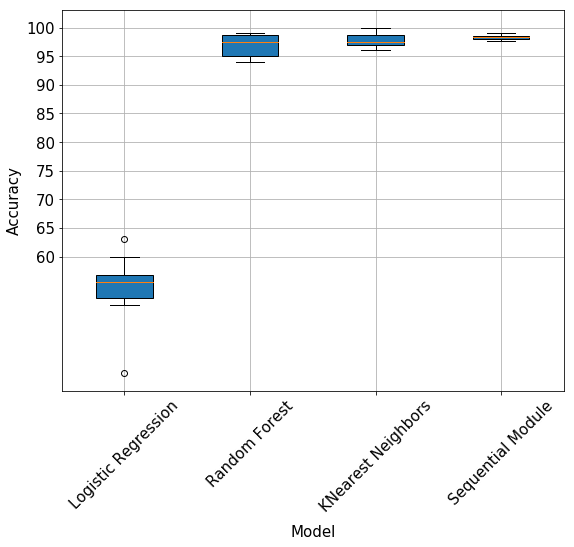

In [21]:
plt.figure(figsize=(9, 7))
ax = plt.axes()
plt.grid()
model_scores = [
   logreg_scores["test_score"]*100,
   randforest_scores["test_score"]*100,
   knn_scores["test_score"]*100,
   np.array(sequential_scores["test_score"])*100
]
model_names = [
   "Logistic Regression",
   "Random Forest",
   "KNearest Neighbors",
   "Sequential Module"
]

fontdict = {'fontsize': 15 }
# 'verticalalignment': 'baseline'}

ax.boxplot(model_scores, patch_artist=True)
ax.set_ylabel("Accuracy", fontdict=fontdict)
ax.set_yticks(np.arange(60,101,5))
ax.set_xlabel("Model", fontdict=fontdict, labelpad=10)
plt.ylim()



_ = ax.set_xticklabels(model_names, rotation=45, fontdict=fontdict)
_ = ax.set_yticklabels(np.arange(60,101,5), fontdict=fontdict)
# _ = ax.set_xticklabels(model_names, rotation=45)